# EEG-Based Game Rating Classification (PEGI & ESRB)

## Köksal Kerem TANIL - 211805018

This notebook details the process of building machine learning models to predict PEGI (Pan-European Game Information) and ESRB (Entertainment Software Rating Board) age-based content ratings for video games using features derived from EEG signals during gameplay.

## 1. Introduction and Setup

### 1.1. Objective

The primary goal is to develop two separate classification models:
1.  Predict the **PEGI** label (numerical multi-class classification: 3, 7, 12, 16, 18).
2.  Predict the **ESRB** label (categorical multi-class classification: E, T, M).

A key requirement is to handle missing values in the EEG features using **imputation techniques** and to perform **feature selection** or ranking to reduce the input dimensionality without using prohibited techniques like PCA.

### 1.2. Load Libraries

Import necessary Python libraries for data manipulation, preprocessing, modeling, evaluation, and visualization.

### 1.3. Load Data

Load the dataset containing PEGI labels, ESRB labels, and the 2268 EEG-derived features.

In [1]:
import pandas as pd
import numpy as np

file_path = 'project_4.csv'
df = pd.read_csv(file_path) 

## 2. Data Exploration and Understanding (EDA)

Perform initial exploratory data analysis to understand the dataset's structure, content, and potential issues.

### 2.1. Dataset Dimensions
Check the number of rows (samples) and columns (features + targets).

In [2]:
print("\n1. Veri Setinin Boyutları:")
print(f"Satır sayısı: {df.shape[0]}")
print(f"Sütun sayısı: {df.shape[1]}")


1. Veri Setinin Boyutları:
Satır sayısı: 900
Sütun sayısı: 2270


### 2.2. Initial Data Preview
Display the first few rows to get a feel for the data values and column names.

In [3]:
print(df.head())

   PEGI  ESRB  RMS_50_EEG.AF3  MAX_50_EEG.AF3  MIN_50_EEG.AF3  MA_50_EEG.AF3  \
0    12  teen        1.271920       -0.296349       -1.966410      -1.187020   
1    12  teen        1.260510        1.949350        0.417872       1.198790   
2    12  teen        1.639400        2.041750        1.315090       1.629100   
3    12  teen        1.452530       -0.219947       -2.419460      -1.355240   
4    12  teen        0.280988        0.568889       -0.138220       0.227379   

   STD_50_EEG.AF3  PTP_50_EEG.AF3  Kurtosis_50_EEG.AF3  \
0        0.456894        1.670060            -0.882631   
1        0.389617        1.531480            -0.880739   
2        0.183527        0.726658            -0.714075   
3        0.522655        2.199510            -0.436060   
4        0.165085        0.707109            -0.490836   

   ZeroCrossing_50_EEG.AF3  ...  CrestFactor_100_POW.AF4.Gamma  \
0                      0.0  ...                        1.01742   
1                      0.0  ...       

### 2.3. Data Types and Non-Null Counts
Use `.info()` to check the data type of each column and identify columns with potential missing values (by comparing non-null counts to the total number of rows).

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Columns: 2270 entries, PEGI to CrestFactor_200_POW.AF4.Gamma
dtypes: float64(2242), int64(27), object(1)
memory usage: 15.6+ MB


### 2.4. Descriptive Statistics
Use `.describe()` to get summary statistics (count, mean, std, min, max, percentiles) for numerical features. This helps understand the scale and distribution of EEG features.

In [9]:
df.describe()

,PEGI,RMS_50_EEG.AF3,MAX_50_EEG.AF3,MIN_50_EEG.AF3,MA_50_EEG.AF3,STD_50_EEG.AF3,PTP_50_EEG.AF3,Kurtosis_50_EEG.AF3,ZeroCrossing_50_EEG.AF3,CrestFactor_50_EEG.AF3,...,CrestFactor_100_POW.AF4.Gamma,RMS_200_POW.AF4.Gamma,MAX_200_POW.AF4.Gamma,MIN_200_POW.AF4.Gamma,MA_200_POW.AF4.Gamma,STD_200_POW.AF4.Gamma,PTP_200_POW.AF4.Gamma,Kurtosis_200_POW.AF4.Gamma,ZeroCrossing_200_POW.AF4.Gamma,CrestFactor_200_POW.AF4.Gamma
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,...,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,11.140000,0.555750,0.493747,-0.447090,-0.012278,0.243468,0.940837,-0.237258,4.168889,1.969623,...,1.022531,0.229485,0.027316,-0.020837,0.002239,0.014979,0.048153,-0.764415,0.004444,1.032206
std,5.606722,0.692223,0.943914,0.891645,0.823552,0.225041,0.749644,1.003203,4.784142,0.472620,...,0.085635,0.989991,1.206247,0.841392,1.002109,0.168379,0.535422,1.161889,0.094228,0.075822
min,3.000000,0.075874,-8.577380,-10.366500,-9.192600,0.065256,0.275387,-1.691550,0.000000,1.073100,...,1.000000,0.021762,-0.122759,-0.123952,-0.123353,0.000000,0.000000,-1.779060,0.000000,1.000000
25%,7.000000,0.202643,0.113620,-0.630361,-0.227554,0.128005,0.541437,-0.822181,0.000000,1.616083,...,1.004548,0.112809,-0.118797,-0.121570,-0.120184,0.000701,0.002292,-1.434157,0.000000,1.008465
50%,12.000000,0.324627,0.373456,-0.348760,0.003342,0.172955,0.713328,-0.430813,3.000000,1.942165,...,1.009595,0.118068,-0.115610,-0.119981,-0.117846,0.001296,0.004108,-1.160160,0.000000,1.015655
75%,16.000000,0.651466,0.736787,-0.107576,0.237551,0.246677,0.993603,0.072679,7.000000,2.298430,...,1.019520,0.120367,-0.108092,-0.115296,-0.111901,0.002212,0.006783,-0.539137,0.000000,1.028268
max,18.000000,9.206480,6.309290,3.589220,4.384600,2.107750,6.893460,10.033700,25.000000,4.027560,...,3.174160,11.199300,14.024400,8.962620,10.929300,3.085960,9.131730,8.853130,2.000000,1.986600


### 2.5. Missing Value Analysis
Explicitly calculate and display the number and percentage of missing values (NaN) per column. Confirm the presence of missing data as stated in the dataset overview.


In [10]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

In [12]:
missing_info = pd.DataFrame({
    'Eksik Değer Sayısı': missing_values[missing_values > 0],
    'Eksik Değer Oranı (%)': missing_percentage[missing_values > 0]
})
print(missing_info.sort_values(by='Eksik Değer Sayısı', ascending=False))

                      Eksik Değer Sayısı  Eksik Değer Oranı (%)
MIN_200_POW.O2.Theta                  41               4.555556
MAX_200_POW.O2.Theta                  18               2.000000
MA_200_POW.O2.Theta                   12               1.333333


In [14]:
total_missing_count = missing_values.sum()
print(f"\nVeri setindeki toplam eksik değer sayısı: {total_missing_count}")
if total_missing_count > 0:
    print("Eksik değerler bulundu.")
else:
    print("Veri setinde eksik değer bulunmuyor.")


Veri setindeki toplam eksik değer sayısı: 71
Eksik değerler bulundu.


### 2.6. Target Variable Distribution
Examine the distribution of classes within the PEGI and ESRB target variables using `.value_counts()`. This is crucial for understanding class balance/imbalance.

In [16]:
print("\nPEGI Etiket Dağılımı:")
print(df['PEGI'].value_counts(normalize=True).sort_index())


PEGI Etiket Dağılımı:
PEGI
3     0.206667
7     0.200000
12    0.193333
16    0.200000
18    0.200000
Name: proportion, dtype: float64


In [17]:
print("\nESRB Etiket Dağılımı:")
print(df['ESRB'].value_counts(normalize=True))


ESRB Etiket Dağılımı:
ESRB
teen        0.593333
everyone    0.206667
mature      0.200000
Name: proportion, dtype: float64


## 3. Data Preprocessing

Prepare the data for modeling by handling missing values, scaling features, splitting the data, selecting relevant features, and encoding the categorical target variable.

### 3.1. Separate Features (X) and Targets (y)
Isolate the input EEG features (X) from the target variables (y_pegi, y_esrb).

In [18]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

target_pegi = df['PEGI']
target_esrb = df['ESRB']

features_df = df.drop(columns=['PEGI', 'ESRB']) 
feature_names = features_df.columns

### 3.2. Scaling EEG Features (StandardScaler)
Scale the numerical EEG features using `StandardScaler`. This is important because `KNNImputer` (used next) is distance-based and sensitive to feature scales. Scaling ensures all features contribute more equally to the distance calculations.

In [19]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

In [20]:
features_scaled_df = pd.DataFrame(features_scaled, columns=feature_names, index=df.index) 
print("\nEEG Özellikleri ölçeklendirildi (StandardScaler).")

print(f"Ölçeklendirme sonrası eksik değer sayısı: {np.isnan(features_scaled).sum()}")


EEG Özellikleri ölçeklendirildi (StandardScaler).
Ölçeklendirme sonrası eksik değer sayısı: 71


### 3.3. Handling Missing Values (KNNImputer)
Apply `KNNImputer` to fill in the missing values (NaN) identified during EDA. We will start with `k=5` neighbors as suggested and optimize this later. Imputation is performed on the scaled features.

In [21]:
k_value = 5
imputer = KNNImputer(n_neighbors=k_value)

In [22]:
print(f"\nKNNImputer (k={k_value}) uygulanıyor...")
features_imputed_scaled = imputer.fit_transform(features_scaled) 
print("KNNImputer tamamlandı.")


KNNImputer (k=5) uygulanıyor...
KNNImputer tamamlandı.


In [23]:
remaining_nan = np.isnan(features_imputed_scaled).sum()
if remaining_nan == 0:
    print("\nBaşarılı: İmputasyon sonrası eksik değer kalmadı.")
else:
    print(f"\nUyarı: İmputasyon sonrası hala {remaining_nan} eksik değer var!")


Başarılı: İmputasyon sonrası eksik değer kalmadı.


In [24]:
features_imputed_scaled_df = pd.DataFrame(features_imputed_scaled, columns=feature_names, index=df.index)

In [25]:
print("\nİmpute edilmiş ve ölçeklenmiş özelliklerin ilk 5 satırı:")
print(features_imputed_scaled_df.head())


İmpute edilmiş ve ölçeklenmiş özelliklerin ilk 5 satırı:
   RMS_50_EEG.AF3  MAX_50_EEG.AF3  MIN_50_EEG.AF3  MA_50_EEG.AF3  \
0        1.035169       -0.837507       -1.704898      -1.427226   
1        1.018677        1.542950        0.970613       1.471360   
2        1.566333        1.640895        1.977423       1.994156   
3        1.296227       -0.756520       -2.213286      -1.631601   
4       -0.397148        0.079651        0.346597       0.291166   

   STD_50_EEG.AF3  PTP_50_EEG.AF3  Kurtosis_50_EEG.AF3  \
0        0.948917        0.973301            -0.643670   
1        0.649796        0.788337            -0.641783   
2       -0.266502       -0.285866            -0.475559   
3        1.241298        1.679963            -0.198277   
4       -0.348497       -0.311958            -0.252909   

   ZeroCrossing_50_EEG.AF3  CrestFactor_50_EEG.AF3  RMS_100_EEG.AF3  ...  \
0                -0.871882               -0.896784         1.712627  ...   
1                -0.871882      

In [26]:
print("\nÖnceden eksik değer içeren sütunların imputasyon sonrası durumu (ilk 5 satır):")
original_missing_cols = ['MIN_200_POW.O2.Theta', 'MAX_200_POW.O2.Theta', 'MA_200_POW.O2.Theta']
print(features_imputed_scaled_df[original_missing_cols].head())


Önceden eksik değer içeren sütunların imputasyon sonrası durumu (ilk 5 satır):
   MIN_200_POW.O2.Theta  MAX_200_POW.O2.Theta  MA_200_POW.O2.Theta
0              1.688453              0.744510             0.876041
1              2.593391              0.864117             1.395992
2              1.538915              0.864117             1.149820
3              1.488943              0.509652             0.654990
4              1.488943              0.629739             0.869131


In [27]:
X_processed = features_imputed_scaled_df
y_pegi = target_pegi
y_esrb = target_esrb

### 3.4. Splitting Data into Training and Test Sets (train_test_split)
Divide the processed features and corresponding targets into training and testing sets. Use `stratify` on the target variables (both PEGI and ESRB) to ensure that the class proportions are maintained in both sets, which is especially important for the imbalanced ESRB dataset.

In [28]:
from sklearn.model_selection import train_test_split

test_size_ratio = 0.20
random_state_value = 42

In [29]:
X_train_pegi, X_test_pegi, y_train_pegi, y_test_pegi = train_test_split(
    X_processed, 
    y_pegi, 
    test_size=test_size_ratio, 
    random_state=random_state_value, 
    stratify=y_pegi
)

print("\nPEGI için veri ayırma tamamlandı:")
print(f"Eğitim seti boyutu (X_train_pegi): {X_train_pegi.shape}")
print(f"Test seti boyutu (X_test_pegi):   {X_test_pegi.shape}")
print(f"Eğitim hedef boyutu (y_train_pegi): {y_train_pegi.shape}")
print(f"Test hedef boyutu (y_test_pegi):   {y_test_pegi.shape}")


PEGI için veri ayırma tamamlandı:
Eğitim seti boyutu (X_train_pegi): (720, 2268)
Test seti boyutu (X_test_pegi):   (180, 2268)
Eğitim hedef boyutu (y_train_pegi): (720,)
Test hedef boyutu (y_test_pegi):   (180,)


In [30]:
X_train_esrb, X_test_esrb, y_train_esrb, y_test_esrb = train_test_split(
    X_processed, 
    y_esrb, 
    test_size=test_size_ratio, 
    random_state=random_state_value, 
    stratify=y_esrb
)

print("\nESRB için veri ayırma tamamlandı:")
print(f"Eğitim seti boyutu (X_train_esrb): {X_train_esrb.shape}")
print(f"Test seti boyutu (X_test_esrb):   {X_test_esrb.shape}")
print(f"Eğitim hedef boyutu (y_train_esrb): {y_train_esrb.shape}")
print(f"Test hedef boyutu (y_test_esrb):   {y_test_esrb.shape}")


ESRB için veri ayırma tamamlandı:
Eğitim seti boyutu (X_train_esrb): (720, 2268)
Test seti boyutu (X_test_esrb):   (180, 2268)
Eğitim hedef boyutu (y_train_esrb): (720,)
Test hedef boyutu (y_test_esrb):   (180,)


### 3.5. Feature Selection (SelectKBest)
Apply `SelectKBest` with the `f_classif` (ANOVA F-test) scoring function to select a subset of the most relevant features for classification. This is a mandatory step according to the project restrictions.
- Fit `SelectKBest` **only** on the training data (`X_train`) to avoid data leakage from the test set.
- Transform both the training (`X_train`) and test (`X_test`) sets using the fitted selector.
- We will start with `k=100` features and optimize this value later.
- Feature selection is performed separately for PEGI and ESRB targets.

In [31]:
from sklearn.feature_selection import SelectKBest, f_classif

k_best_features = 100
print(f"\nPEGI için en iyi {k_best_features} özellik seçiliyor...")

selector_pegi = SelectKBest(score_func=f_classif, k=k_best_features)


PEGI için en iyi 100 özellik seçiliyor...


In [32]:
selector_pegi.fit(X_train_pegi, y_train_pegi)

C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1411 1420 1429 1573 1582 1591] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


SelectKBest(k=100)

In [33]:
selected_indices_pegi = selector_pegi.get_support(indices=True)
selected_features_names_pegi = X_processed.columns[selected_indices_pegi]

In [34]:
X_train_pegi_selected = selector_pegi.transform(X_train_pegi)
X_test_pegi_selected = selector_pegi.transform(X_test_pegi)

In [35]:
print("PEGI için özellik seçimi tamamlandı.")
print(f"Eğitim seti yeni boyutu: {X_train_pegi_selected.shape}")
print(f"Test seti yeni boyutu:   {X_test_pegi_selected.shape}")

PEGI için özellik seçimi tamamlandı.
Eğitim seti yeni boyutu: (720, 100)
Test seti yeni boyutu:   (180, 100)


### 3.6. Encoding Categorical Target (ESRB)
Convert the categorical ESRB labels (e.g., 'E', 'T', 'M') into numerical representations using `LabelEncoder`, as most machine learning models require numerical input for the target variable. Fit the encoder only on the training labels and transform both training and test labels.

In [36]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train_esrb_encoded = le.fit_transform(y_train_esrb) 

In [37]:
y_test_esrb_encoded = le.transform(y_test_esrb) 

In [38]:
print("\nESRB etiketleri LabelEncoder ile sayısala dönüştürüldü:")
print("Sınıflar:", le.classes_)


ESRB etiketleri LabelEncoder ile sayısala dönüştürüldü:
Sınıflar: ['everyone' 'mature' 'teen']


In [39]:
print(f"\nESRB için en iyi {k_best_features} özellik seçiliyor...")


ESRB için en iyi 100 özellik seçiliyor...


In [40]:
selector_esrb = SelectKBest(score_func=f_classif, k=k_best_features)

In [41]:
selector_esrb.fit(X_train_esrb, y_train_esrb_encoded) 

C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1411 1420 1429 1573 1582 1591] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


SelectKBest(k=100)

In [42]:
selected_indices_esrb = selector_esrb.get_support(indices=True)
selected_features_names_esrb = X_processed.columns[selected_indices_esrb]

In [43]:
X_train_esrb_selected = selector_esrb.transform(X_train_esrb)
X_test_esrb_selected = selector_esrb.transform(X_test_esrb)

In [44]:
print("ESRB için özellik seçimi tamamlandı.")
print(f"Eğitim seti yeni boyutu: {X_train_esrb_selected.shape}")
print(f"Test seti yeni boyutu:   {X_test_esrb_selected.shape}")

ESRB için özellik seçimi tamamlandı.
Eğitim seti yeni boyutu: (720, 100)
Test seti yeni boyutu:   (180, 100)


## 4. Initial Model Training and Evaluation

Train several baseline classification models on the preprocessed data (with k=100 features and k=5 imputation) to establish initial performance benchmarks. Evaluate models separately for the PEGI and ESRB tasks.

### 4.1. Define Models
Instantiate the classifiers to be tested: Logistic Regression, SVM (SVC), RandomForest, Gradient Boosting, and K-Nearest Neighbors. Use default or common starting hyperparameters.

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np

models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000, multi_class='auto', solver='lbfgs'), 
    "SVM (SVC)": SVC(random_state=42, probability=True),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100), 
    "Gradient Boosting": GradientBoostingClassifier(random_state=42, n_estimators=100),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

In [47]:
pegi_results_list = []
esrb_results_list = []

print("\n" + "="*25 + " PEGI Sınıflandırması " + "="*25)


========================= PEGI Sınıflandırması =========================


In [51]:
try:
    pegi_target_names = [str(c) for c in sorted(np.unique(y_train_pegi))]
    print("pegi_target_names başarıyla oluşturuldu:", pegi_target_names)

    le = LabelEncoder()
    y_train_esrb_encoded = le.fit_transform(y_train_esrb)
    y_test_esrb_encoded = le.transform(y_test_esrb)  
    esrb_target_names = le.classes_ 
    print("esrb_target_names başarıyla alındı:", esrb_target_names)
    print("ESRB Eğitim etiketleri kodlandı.")

    pegi_results_list = []
    esrb_results_list = []
    print("Sonuç listeleri başarıyla oluşturuldu.")

except NameError as e:
    print(f"HATA: Gerekli bir değişken bulunamadı ({e}). Lütfen veri hazırlama adımlarını kontrol edin.")

except Exception as e:
    print(f"HATA: Hedef isimleri veya listeler oluşturulurken bir sorun oluştu: {e}")

print("\n" + "="*25 + " PEGI Sınıflandırması " + "="*25)

pegi_target_names başarıyla oluşturuldu: ['3', '7', '12', '16', '18']
esrb_target_names başarıyla alındı: ['everyone' 'mature' 'teen']
ESRB Eğitim etiketleri kodlandı.
Sonuç listeleri başarıyla oluşturuldu.

========================= PEGI Sınıflandırması =========================


### 4.2. Train and Evaluate Models (PEGI)
For each model:
- Train on the selected PEGI training data (`X_train_pegi_selected`, `y_train_pegi`).
- Predict on the selected PEGI test data (`X_test_pegi_selected`).
- Evaluate using accuracy, classification report (precision, recall, F1-score), and confusion matrix.


--- Model: Logistic Regression ---
Eğitim Süresi: 0.04 saniye
Tahmin Süresi: 0.0010 saniye
Test Seti Doğruluğu (Accuracy): 0.3056
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           3       0.31      0.22      0.25        37
           7       0.39      0.44      0.42        36
          12       0.33      0.29      0.31        35
          16       0.19      0.19      0.19        36
          18       0.30      0.39      0.34        36

    accuracy                           0.31       180
   macro avg       0.30      0.31      0.30       180
weighted avg       0.30      0.31      0.30       180



C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


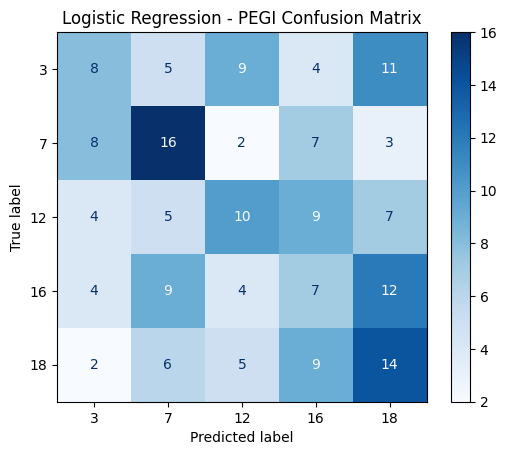


--- Model: SVM (SVC) ---
Eğitim Süresi: 0.15 saniye
Tahmin Süresi: 0.0116 saniye
Test Seti Doğruluğu (Accuracy): 0.3722
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           3       0.45      0.41      0.43        37
           7       0.44      0.50      0.47        36
          12       0.39      0.26      0.31        35
          16       0.21      0.28      0.24        36
          18       0.42      0.42      0.42        36

    accuracy                           0.37       180
   macro avg       0.38      0.37      0.37       180
weighted avg       0.38      0.37      0.37       180



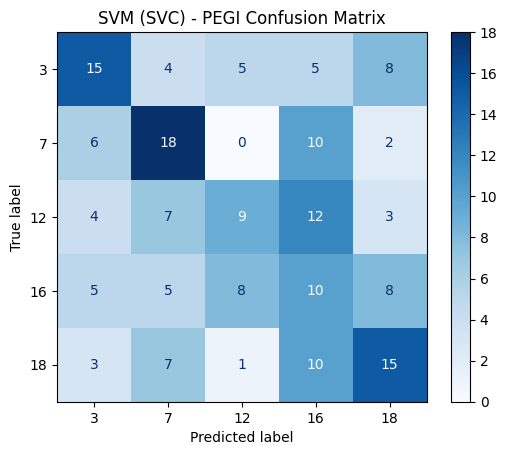


--- Model: Random Forest ---
Eğitim Süresi: 0.52 saniye
Tahmin Süresi: 0.0081 saniye
Test Seti Doğruluğu (Accuracy): 0.5278
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           3       0.65      0.65      0.65        37
           7       0.57      0.47      0.52        36
          12       0.50      0.49      0.49        35
          16       0.48      0.58      0.53        36
          18       0.46      0.44      0.45        36

    accuracy                           0.53       180
   macro avg       0.53      0.53      0.53       180
weighted avg       0.53      0.53      0.53       180



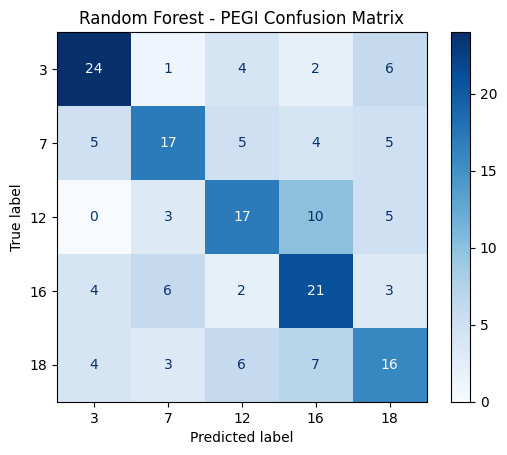


--- Model: Gradient Boosting ---
Eğitim Süresi: 8.78 saniye
Tahmin Süresi: 0.0044 saniye
Test Seti Doğruluğu (Accuracy): 0.4611
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           3       0.49      0.49      0.49        37
           7       0.55      0.50      0.52        36
          12       0.52      0.46      0.48        35
          16       0.32      0.33      0.33        36
          18       0.45      0.53      0.49        36

    accuracy                           0.46       180
   macro avg       0.46      0.46      0.46       180
weighted avg       0.46      0.46      0.46       180



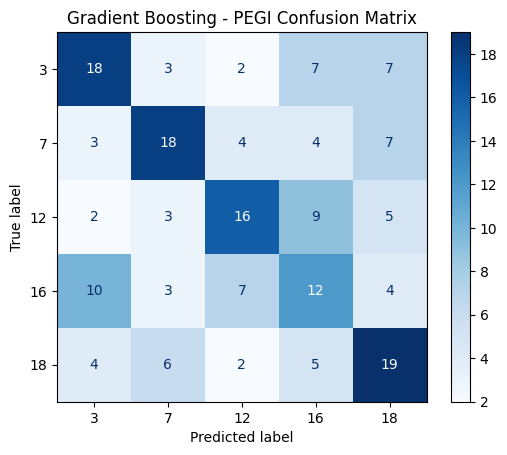


--- Model: K-Nearest Neighbors ---
Eğitim Süresi: 0.00 saniye
Tahmin Süresi: 0.1704 saniye
Test Seti Doğruluğu (Accuracy): 0.3833
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           3       0.40      0.49      0.44        37
           7       0.48      0.58      0.53        36
          12       0.36      0.34      0.35        35
          16       0.32      0.33      0.33        36
          18       0.29      0.17      0.21        36

    accuracy                           0.38       180
   macro avg       0.37      0.38      0.37       180
weighted avg       0.37      0.38      0.37       180



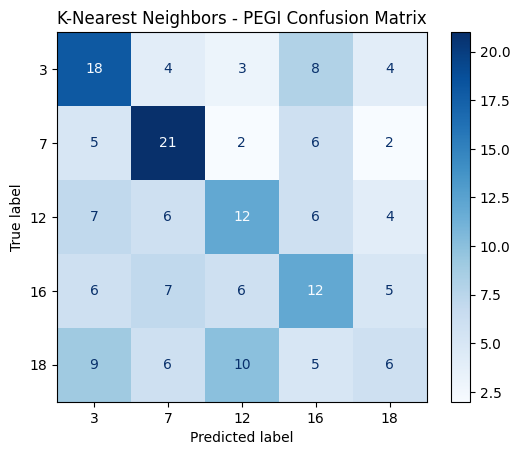

In [52]:
for model_name, model in models.items():
    print(f"\n--- Model: {model_name} ---")
    
    start_time = time.time()
    
    model.fit(X_train_pegi_selected, y_train_pegi) 
    end_time = time.time()
    train_time = end_time - start_time
    print(f"Eğitim Süresi: {train_time:.2f} saniye")
    
    start_time = time.time()
    y_pred_pegi = model.predict(X_test_pegi_selected)
    end_time = time.time()
    predict_time = end_time - start_time
    print(f"Tahmin Süresi: {predict_time:.4f} saniye")

    accuracy = accuracy_score(y_test_pegi, y_pred_pegi)
    
    report_dict = classification_report(y_test_pegi, y_pred_pegi, target_names=pegi_target_names, output_dict=True) 
    report_str = classification_report(y_test_pegi, y_pred_pegi, target_names=pegi_target_names)

    pegi_results_list.append({  
        'Model': model_name,
        'Accuracy': accuracy,
        'Weighted F1': report_dict['weighted avg']['f1-score'], 
        'Macro F1': report_dict['macro avg']['f1-score'],       
        'Train Time (s)': train_time
    })
    
    print(f"Test Seti Doğruluğu (Accuracy): {accuracy:.4f}")
    print("Sınıflandırma Raporu:")
    print(report_str)
    
    try:
        cm = confusion_matrix(y_test_pegi, y_pred_pegi)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pegi_target_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'{model_name} - PEGI Confusion Matrix')
        plt.show()
    except Exception as e:
        print(f"Karmaşıklık Matrisi çizilemedi: {e}")

### 4.3. Train and Evaluate Models (ESRB)
For each model:
- Train on the selected ESRB training data (`X_train_esrb_selected`, `y_train_esrb_encoded`).
- Predict on the selected ESRB test data (`X_test_esrb_selected`).
- Evaluate using accuracy, classification report (with original class names), and confusion matrix.


========================= ESRB Sınıflandırması =========================

--- Model: Logistic Regression ---
Eğitim Süresi: 0.05 saniye
Tahmin Süresi: 0.0000 saniye
Test Seti Doğruluğu (Accuracy): 0.5944
Sınıflandırma Raporu:
              precision    recall  f1-score   support

    everyone       0.43      0.16      0.24        37
      mature       0.46      0.17      0.24        36
        teen       0.62      0.89      0.73       107

    accuracy                           0.59       180
   macro avg       0.50      0.41      0.40       180
weighted avg       0.55      0.59      0.53       180



C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


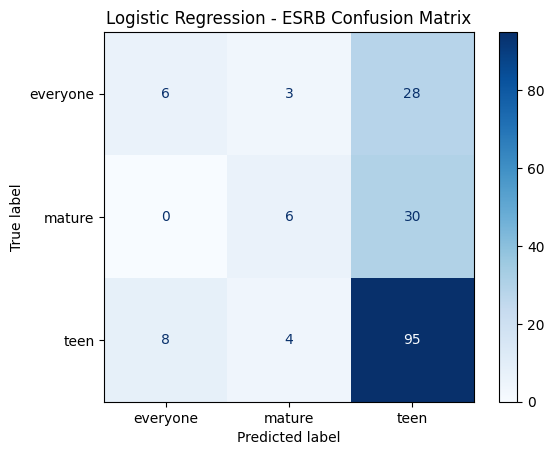


--- Model: SVM (SVC) ---
Eğitim Süresi: 0.10 saniye
Tahmin Süresi: 0.0065 saniye
Test Seti Doğruluğu (Accuracy): 0.6333
Sınıflandırma Raporu:
              precision    recall  f1-score   support

    everyone       0.80      0.11      0.19        37
      mature       0.67      0.11      0.19        36
        teen       0.63      0.99      0.77       107

    accuracy                           0.63       180
   macro avg       0.70      0.40      0.38       180
weighted avg       0.67      0.63      0.53       180



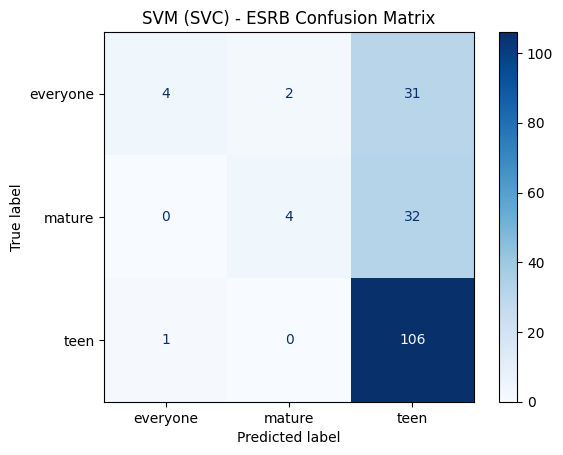


--- Model: Random Forest ---
Eğitim Süresi: 0.52 saniye
Tahmin Süresi: 0.0060 saniye
Test Seti Doğruluğu (Accuracy): 0.6722
Sınıflandırma Raporu:
              precision    recall  f1-score   support

    everyone       0.82      0.24      0.38        37
      mature       0.80      0.22      0.35        36
        teen       0.65      0.97      0.78       107

    accuracy                           0.67       180
   macro avg       0.76      0.48      0.50       180
weighted avg       0.72      0.67      0.61       180



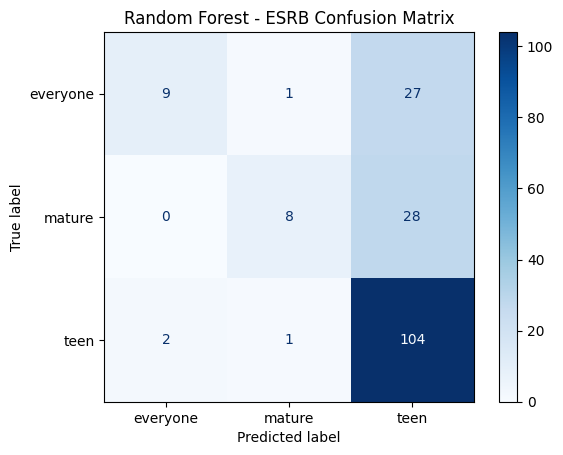


--- Model: Gradient Boosting ---
Eğitim Süresi: 5.72 saniye
Tahmin Süresi: 0.0020 saniye
Test Seti Doğruluğu (Accuracy): 0.6611
Sınıflandırma Raporu:
              precision    recall  f1-score   support

    everyone       0.47      0.22      0.30        37
      mature       0.68      0.36      0.47        36
        teen       0.68      0.92      0.78       107

    accuracy                           0.66       180
   macro avg       0.61      0.50      0.52       180
weighted avg       0.64      0.66      0.62       180



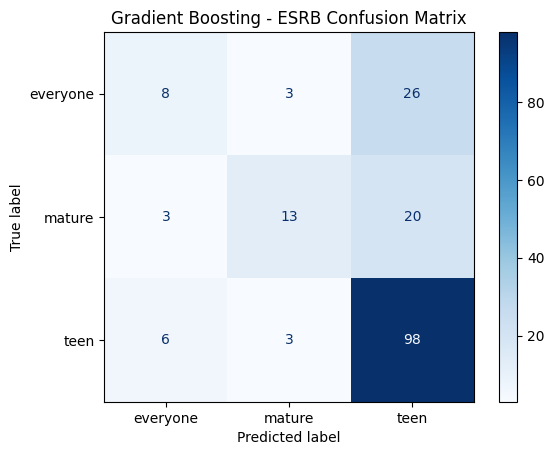


--- Model: K-Nearest Neighbors ---
Eğitim Süresi: 0.00 saniye
Tahmin Süresi: 0.0112 saniye
Test Seti Doğruluğu (Accuracy): 0.6222
Sınıflandırma Raporu:
              precision    recall  f1-score   support

    everyone       0.44      0.38      0.41        37
      mature       0.53      0.28      0.36        36
        teen       0.68      0.82      0.75       107

    accuracy                           0.62       180
   macro avg       0.55      0.49      0.51       180
weighted avg       0.60      0.62      0.60       180



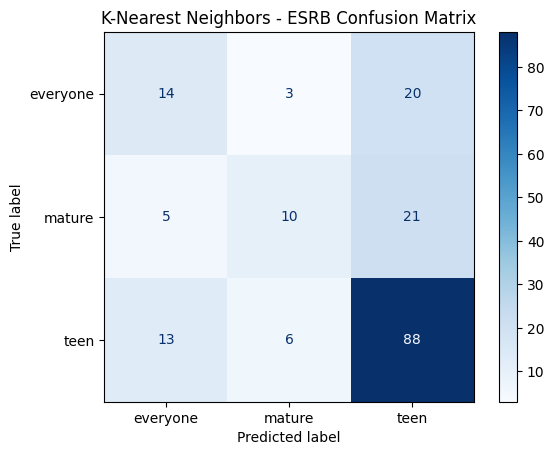


========================= Model Karşılaştırma Özeti =========================

PEGI Modelleri Performans Özeti (Weighted F1'e göre sıralı):
              Model  Accuracy  Weighted F1  Macro F1  Train Time (s)
      Random Forest  0.527778     0.527318  0.526452        0.518709
  Gradient Boosting  0.461111     0.461813  0.461804        8.781036
          SVM (SVC)  0.372222     0.373473  0.372816        0.147470
K-Nearest Neighbors  0.383333     0.371730  0.371252        0.001000
Logistic Regression  0.305556     0.301509  0.301808        0.036910

ESRB Modelleri Performans Özeti (Weighted F1'e göre sıralı):
              Model  Accuracy  Weighted F1  Macro F1  Train Time (s)
  Gradient Boosting  0.661111     0.619638  0.516633        5.724906
      Random Forest  0.672222     0.611477  0.501594        0.518157
K-Nearest Neighbors  0.622222     0.599456  0.505065        0.001003
          SVM (SVC)  0.633333     0.533851  0.383023        0.103533
Logistic Regression  0.594444     0.53

In [53]:
print("\n" + "="*25 + " ESRB Sınıflandırması " + "="*25)

for model_name, model in models.items():

    print(f"\n--- Model: {model_name} ---")
    
    start_time = time.time()

    model.fit(X_train_esrb_selected, y_train_esrb_encoded) 
    end_time = time.time()
    train_time = end_time - start_time
    print(f"Eğitim Süresi: {train_time:.2f} saniye")
    
    start_time = time.time()
    y_pred_esrb_encoded = model.predict(X_test_esrb_selected)
    end_time = time.time()
    predict_time = end_time - start_time
    print(f"Tahmin Süresi: {predict_time:.4f} saniye")

    accuracy = accuracy_score(y_test_esrb_encoded, y_pred_esrb_encoded)
    report_dict = classification_report(y_test_esrb_encoded, y_pred_esrb_encoded, target_names=esrb_target_names, output_dict=True)
    report_str = classification_report(y_test_esrb_encoded, y_pred_esrb_encoded, target_names=esrb_target_names)
    

    esrb_results_list.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Weighted F1': report_dict['weighted avg']['f1-score'],
        'Macro F1': report_dict['macro avg']['f1-score'],
        'Train Time (s)': train_time
    })
    
    print(f"Test Seti Doğruluğu (Accuracy): {accuracy:.4f}")
    print("Sınıflandırma Raporu:")
    print(report_str)
  
    try:
        cm = confusion_matrix(y_test_esrb_encoded, y_pred_esrb_encoded)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=esrb_target_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'{model_name} - ESRB Confusion Matrix')
        plt.show()
    except Exception as e:
        print(f"Karmaşıklık Matrisi çizilemedi: {e}")


print("\n" + "="*25 + " Model Karşılaştırma Özeti " + "="*25)

pegi_results_df = pd.DataFrame(pegi_results_list).sort_values(by='Weighted F1', ascending=False)
print("\nPEGI Modelleri Performans Özeti (Weighted F1'e göre sıralı):")
print(pegi_results_df.to_string(index=False)) # to_string tüm satırları gösterir

esrb_results_df = pd.DataFrame(esrb_results_list).sort_values(by='Weighted F1', ascending=False)
print("\nESRB Modelleri Performans Özeti (Weighted F1'e göre sıralı):")
print(esrb_results_df.to_string(index=False))

### 4.4. Initial Model Comparison Summary
Present a summary table comparing the performance (e.g., Accuracy, Weighted F1, Macro F1, Training Time) of the different models on both tasks. Identify the most promising model(s) for further optimization.

## 5. Hyperparameter Optimization (GridSearchCV)

Fine-tune the hyperparameters of the most promising model(s) identified in the previous step (RandomForestClassifier showed good initial results for both tasks) using `GridSearchCV`. The goal is to find the combination of parameters that yields the best cross-validation performance on the training data.

### 5.1. Focus on RandomForestClassifier
Select RandomForestClassifier for hyperparameter tuning based on initial results.

### 5.2. Define Parameter Grid
Specify the grid of hyperparameters and their respective values to search over (e.g., `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`).

### 5.3. Run GridSearchCV for PEGI
Perform Grid Search using k-fold cross-validation (e.g., 5 folds) on the PEGI training data (with k=100 features). Use an appropriate scoring metric like `f1_weighted`.

### 5.4. Run GridSearchCV for ESRB
Perform a separate Grid Search for the ESRB task on its training data (with k=100 features and encoded labels).

### 5.5. Evaluate Optimized Models on Test Set
Evaluate the best models found by Grid Search ( `grid_search.best_estimator_`) on the respective **test sets** to assess their generalization performance after tuning. Compare these results to the baseline models.

In [54]:
from sklearn.model_selection import GridSearchCV
import time

print("\nMadde 4: Hiperparametre Optimizasyonu (GridSearchCV - RandomForest)")

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],        
    'min_samples_split': [2, 5, 10],       
    'min_samples_leaf': [1, 3, 5],       
    'max_features': ['sqrt', 'log2']    
}

cv_folds = 5 

scoring_metric = 'f1_weighted' 


print(f"\n{'-'*15} PEGI için RandomForest Optimizasyonu {'-'*15}")
print(f"Parametre Izgarası Boyutu: {len(param_grid_rf['n_estimators']) * len(param_grid_rf['max_depth']) * len(param_grid_rf['min_samples_split']) * len(param_grid_rf['min_samples_leaf']) * len(param_grid_rf['max_features'])} kombinasyon")
print(f"Çapraz Doğrulama: {cv_folds} kat")
print("Grid Search başlıyor (Bu işlem zaman alabilir)...")

rf_base_pegi = RandomForestClassifier(random_state=42) 

grid_search_pegi = GridSearchCV(
    estimator=rf_base_pegi, 
    param_grid=param_grid_rf, 
    cv=cv_folds, 
    scoring=scoring_metric, 
    n_jobs=-1, 
    verbose=1  
)

start_time = time.time()

grid_search_pegi.fit(X_train_pegi_selected, y_train_pegi) 
end_time = time.time()
print(f"PEGI Grid Search Süresi: {end_time - start_time:.2f} saniye")

print("\nPEGI için En İyi Parametreler:")
print(grid_search_pegi.best_params_)
print(f"En İyi Çapraz Doğrulama Skoru ({scoring_metric}): {grid_search_pegi.best_score_:.4f}")


best_rf_pegi = grid_search_pegi.best_estimator_

print("\nEn İyi PEGI Modelinin Test Seti Performansı:")
y_pred_pegi_best = best_rf_pegi.predict(X_test_pegi_selected)
accuracy_pegi_best = accuracy_score(y_test_pegi, y_pred_pegi_best)
report_pegi_best = classification_report(y_test_pegi, y_pred_pegi_best, target_names=pegi_target_names)

print(f"Test Seti Doğruluğu: {accuracy_pegi_best:.4f}")
print("Sınıflandırma Raporu:")
print(report_pegi_best)

print(f"\n{'-'*15} ESRB için RandomForest Optimizasyonu {'-'*15}")
print(f"Parametre Izgarası Boyutu: {len(param_grid_rf['n_estimators']) * len(param_grid_rf['max_depth']) * len(param_grid_rf['min_samples_split']) * len(param_grid_rf['min_samples_leaf']) * len(param_grid_rf['max_features'])} kombinasyon")
print(f"Çapraz Doğrulama: {cv_folds} kat")
print("Grid Search başlıyor (Bu işlem zaman alabilir)...")

rf_base_esrb = RandomForestClassifier(random_state=42) 

grid_search_esrb = GridSearchCV(
    estimator=rf_base_esrb, 
    param_grid=param_grid_rf, 
    cv=cv_folds, 
    scoring=scoring_metric, 
    n_jobs=-1, 
    verbose=1 
)

start_time = time.time()

grid_search_esrb.fit(X_train_esrb_selected, y_train_esrb_encoded) 
end_time = time.time()
print(f"ESRB Grid Search Süresi: {end_time - start_time:.2f} saniye")


print("\nESRB için En İyi Parametreler:")
print(grid_search_esrb.best_params_)
print(f"En İyi Çapraz Doğrulama Skoru ({scoring_metric}): {grid_search_esrb.best_score_:.4f}")


best_rf_esrb = grid_search_esrb.best_estimator_


print("\nEn İyi ESRB Modelinin Test Seti Performansı:")
y_pred_esrb_best_encoded = best_rf_esrb.predict(X_test_esrb_selected)
accuracy_esrb_best = accuracy_score(y_test_esrb_encoded, y_pred_esrb_best_encoded)

report_esrb_best = classification_report(y_test_esrb_encoded, y_pred_esrb_best_encoded, target_names=esrb_target_names)

print(f"Test Seti Doğruluğu: {accuracy_esrb_best:.4f}")
print("Sınıflandırma Raporu:")
print(report_esrb_best)

print("\nMadde 4 tamamlandı. RandomForest için hiperparametre optimizasyonu yapıldı.")


Madde 4: Hiperparametre Optimizasyonu (GridSearchCV - RandomForest)

--------------- PEGI için RandomForest Optimizasyonu ---------------
Parametre Izgarası Boyutu: 162 kombinasyon
Çapraz Doğrulama: 5 kat
Grid Search başlıyor (Bu işlem zaman alabilir)...
Fitting 5 folds for each of 162 candidates, totalling 810 fits
PEGI Grid Search Süresi: 41.90 saniye

PEGI için En İyi Parametreler:
{'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
En İyi Çapraz Doğrulama Skoru (f1_weighted): 0.5581

En İyi PEGI Modelinin Test Seti Performansı:
Test Seti Doğruluğu: 0.5778
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           3       0.72      0.57      0.64        37
           7       0.64      0.64      0.64        36
          12       0.54      0.57      0.56        35
          16       0.54      0.58      0.56        36
          18       0.49      0.53      0.51        36

    accuracy               

## 6. Feature Count Optimization (SelectKBest k)

Investigate the impact of the number of selected features (`k` in `SelectKBest`) on the performance of the **optimized RandomForest models**. The objective, as per the project hints, is to find the *smallest number of features that still provides high accuracy*.

### 6.1. Define k Values to Test
Choose a range of `k` values to evaluate (e.g., 25, 50, 75, 100, 125, 150, 175, 200).

### 6.2. Evaluate Optimized Models with Different k
For each `k` value:
1. Re-apply `SelectKBest` with the current `k` (fit on original scaled training data, transform train and test).
2. Re-train the **previously optimized** RandomForest model (found via GridSearchCV) on the newly selected `k` features from the training set.
3. Evaluate the re-trained model on the test set with the corresponding `k` features.
4. Record the performance metrics (Accuracy, Weighted F1, Macro F1).

### 6.3. Analyze Performance vs. Feature Count
Present the results in a table and optionally a plot showing how the model performance changes as `k` varies for both PEGI and ESRB tasks.

### 6.4. Determine Optimal k for PEGI and ESRB
Based on the results and the goal of using the minimum features for high accuracy, select the final `k` value for each task. Note that the `k` yielding the absolute maximum score might not be chosen if a smaller `k` gives very similar performance.

In [55]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import time
import warnings

print("\nMadde 5: Özellik Sayısı Optimizasyonu")

required_vars = ['X_train_pegi', 'X_test_pegi', 'y_train_pegi', 'y_test_pegi', 
                 'X_train_esrb', 'X_test_esrb', 'y_train_esrb_encoded', 'y_test_esrb_encoded',
                 'best_rf_pegi', 'best_rf_esrb', 'pegi_target_names', 'esrb_target_names']

all_vars_exist = True
for var_name in required_vars:
    if var_name not in locals() and var_name not in globals():
        print(f"HATA: Gerekli değişken '{var_name}' bulunamadı!")
        all_vars_exist = False

if not all_vars_exist:
    print("Lütfen önceki adımların doğru çalıştığından ve değişkenlerin tanımlandığından emin olun.")
else:
    X_train_scaled = X_train_pegi 
    X_test_scaled = X_test_pegi
    print("Gerekli değişkenler bulundu, optimizasyon başlıyor...")

k_values_to_test = [25, 50, 75, 100, 125, 150, 175, 200]
print(f"Denenecek k değerleri: {k_values_to_test}")

pegi_k_results = []
esrb_k_results = []

if all_vars_exist: 
    for k in k_values_to_test:
        print(f"\n===== k = {k} Özellik ile Test Ediliyor =====")
        start_k_time = time.time()

        try:
            print(f"PEGI (k={k}): Özellik seçimi...")
            selector_pegi_k = SelectKBest(score_func=f_classif, k=k)

            X_train_pegi_selected_k = selector_pegi_k.fit_transform(X_train_scaled, y_train_pegi)
            X_test_pegi_selected_k = selector_pegi_k.transform(X_test_scaled)
            print(f"PEGI (k={k}): Model eğitimi ({best_rf_pegi.__class__.__name__})...")
            
            best_rf_pegi.fit(X_train_pegi_selected_k, y_train_pegi)
            
            print(f"PEGI (k={k}): Tahmin ve değerlendirme...")
            y_pred_pegi_k = best_rf_pegi.predict(X_test_pegi_selected_k)
            
            accuracy_pegi_k = accuracy_score(y_test_pegi, y_pred_pegi_k)
            report_pegi_k_dict = classification_report(y_test_pegi, y_pred_pegi_k, target_names=pegi_target_names, output_dict=True, zero_division=0)
            
            pegi_k_results.append({
                'k': k,
                'Accuracy': accuracy_pegi_k,
                'Weighted F1': report_pegi_k_dict['weighted avg']['f1-score'],
                'Macro F1': report_pegi_k_dict['macro avg']['f1-score']
            })
            print(f"PEGI (k={k}) - Test Accuracy: {accuracy_pegi_k:.4f}, Weighted F1: {report_pegi_k_dict['weighted avg']['f1-score']:.4f}")

        except Exception as e:
            print(f"PEGI (k={k}) için HATA: {e}")
            pegi_k_results.append({'k': k, 'Accuracy': None, 'Weighted F1': None, 'Macro F1': None})

        try:
            print(f"ESRB (k={k}): Özellik seçimi...")
            selector_esrb_k = SelectKBest(score_func=f_classif, k=k)

            X_train_esrb_selected_k = selector_esrb_k.fit_transform(X_train_scaled, y_train_esrb_encoded)
            X_test_esrb_selected_k = selector_esrb_k.transform(X_test_scaled)
            
            print(f"ESRB (k={k}): Model eğitimi ({best_rf_esrb.__class__.__name__})...")

            best_rf_esrb.fit(X_train_esrb_selected_k, y_train_esrb_encoded)
            
            print(f"ESRB (k={k}): Tahmin ve değerlendirme...")
            y_pred_esrb_k_encoded = best_rf_esrb.predict(X_test_esrb_selected_k)
            
            accuracy_esrb_k = accuracy_score(y_test_esrb_encoded, y_pred_esrb_k_encoded)
            report_esrb_k_dict = classification_report(y_test_esrb_encoded, y_pred_esrb_k_encoded, target_names=esrb_target_names, output_dict=True, zero_division=0)
            
            esrb_k_results.append({
                'k': k,
                'Accuracy': accuracy_esrb_k,
                'Weighted F1': report_esrb_k_dict['weighted avg']['f1-score'],
                'Macro F1': report_esrb_k_dict['macro avg']['f1-score']
            })
            print(f"ESRB (k={k}) - Test Accuracy: {accuracy_esrb_k:.4f}, Weighted F1: {report_esrb_k_dict['weighted avg']['f1-score']:.4f}")

        except Exception as e:
            print(f"ESRB (k={k}) için HATA: {e}")
            esrb_k_results.append({'k': k, 'Accuracy': None, 'Weighted F1': None, 'Macro F1': None})
            
        end_k_time = time.time()
        print(f"k={k} için toplam süre: {end_k_time - start_k_time:.2f} saniye")


    print("\n" + "="*20 + " Özellik Sayısı Optimizasyon Sonuçları " + "="*20)

    pegi_k_results_df = pd.DataFrame(pegi_k_results).sort_values(by='Weighted F1', ascending=False)
    print("\nPEGI için Farklı k Değerlerinin Performansı:")
    print(pegi_k_results_df.to_string(index=False))

    esrb_k_results_df = pd.DataFrame(esrb_k_results).sort_values(by='Weighted F1', ascending=False)
    print("\nESRB için Farklı k Değerlerinin Performansı:")
    print(esrb_k_results_df.to_string(index=False))

    best_pegi_row = pegi_k_results_df.loc[pegi_k_results_df['Weighted F1'].idxmax()]
    best_k_pegi = int(best_pegi_row['k'])
    print(f"\nPEGI için önerilen k değeri (Max Weighted F1): {best_k_pegi} (Weighted F1: {best_pegi_row['Weighted F1']:.4f})")
    
    best_esrb_row = esrb_k_results_df.loc[esrb_k_results_df['Weighted F1'].idxmax()]
    best_k_esrb = int(best_esrb_row['k'])
    print(f"ESRB için önerilen k değeri (Max Weighted F1): {best_k_esrb} (Weighted F1: {best_esrb_row['Weighted F1']:.4f})")


Madde 5: Özellik Sayısı Optimizasyonu
Gerekli değişkenler bulundu, optimizasyon başlıyor...
Denenecek k değerleri: [25, 50, 75, 100, 125, 150, 175, 200]

===== k = 25 Özellik ile Test Ediliyor =====
PEGI (k=25): Özellik seçimi...
PEGI (k=25): Model eğitimi (RandomForestClassifier)...


C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1411 1420 1429 1573 1582 1591] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


PEGI (k=25): Tahmin ve değerlendirme...
PEGI (k=25) - Test Accuracy: 0.4944, Weighted F1: 0.4939
ESRB (k=25): Özellik seçimi...
ESRB (k=25): Model eğitimi (RandomForestClassifier)...
ESRB (k=25): Tahmin ve değerlendirme...
ESRB (k=25) - Test Accuracy: 0.5111, Weighted F1: 0.4066
k=25 için toplam süre: 0.91 saniye

===== k = 50 Özellik ile Test Ediliyor =====
PEGI (k=50): Özellik seçimi...


C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1411 1420 1429 1573 1582 1591] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1411 1420 1429 1573 1582 1591] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


PEGI (k=50): Model eğitimi (RandomForestClassifier)...
PEGI (k=50): Tahmin ve değerlendirme...
PEGI (k=50) - Test Accuracy: 0.5222, Weighted F1: 0.5228
ESRB (k=50): Özellik seçimi...
ESRB (k=50): Model eğitimi (RandomForestClassifier)...


C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1411 1420 1429 1573 1582 1591] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


ESRB (k=50): Tahmin ve değerlendirme...
ESRB (k=50) - Test Accuracy: 0.5500, Weighted F1: 0.4341
k=50 için toplam süre: 0.89 saniye

===== k = 75 Özellik ile Test Ediliyor =====
PEGI (k=75): Özellik seçimi...
PEGI (k=75): Model eğitimi (RandomForestClassifier)...


C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1411 1420 1429 1573 1582 1591] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


PEGI (k=75): Tahmin ve değerlendirme...
PEGI (k=75) - Test Accuracy: 0.5722, Weighted F1: 0.5732
ESRB (k=75): Özellik seçimi...
ESRB (k=75): Model eğitimi (RandomForestClassifier)...


C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1411 1420 1429 1573 1582 1591] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


ESRB (k=75): Tahmin ve değerlendirme...
ESRB (k=75) - Test Accuracy: 0.5944, Weighted F1: 0.4812
k=75 için toplam süre: 0.99 saniye

===== k = 100 Özellik ile Test Ediliyor =====
PEGI (k=100): Özellik seçimi...
PEGI (k=100): Model eğitimi (RandomForestClassifier)...


C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1411 1420 1429 1573 1582 1591] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


PEGI (k=100): Tahmin ve değerlendirme...
PEGI (k=100) - Test Accuracy: 0.5778, Weighted F1: 0.5799
ESRB (k=100): Özellik seçimi...
ESRB (k=100): Model eğitimi (RandomForestClassifier)...


C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1411 1420 1429 1573 1582 1591] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


ESRB (k=100): Tahmin ve değerlendirme...
ESRB (k=100) - Test Accuracy: 0.5722, Weighted F1: 0.4500
k=100 için toplam süre: 1.04 saniye

===== k = 125 Özellik ile Test Ediliyor =====
PEGI (k=125): Özellik seçimi...
PEGI (k=125): Model eğitimi (RandomForestClassifier)...


C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1411 1420 1429 1573 1582 1591] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


PEGI (k=125): Tahmin ve değerlendirme...
PEGI (k=125) - Test Accuracy: 0.5444, Weighted F1: 0.5461
ESRB (k=125): Özellik seçimi...
ESRB (k=125): Model eğitimi (RandomForestClassifier)...


C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1411 1420 1429 1573 1582 1591] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


ESRB (k=125): Tahmin ve değerlendirme...
ESRB (k=125) - Test Accuracy: 0.5722, Weighted F1: 0.4439
k=125 için toplam süre: 1.05 saniye

===== k = 150 Özellik ile Test Ediliyor =====
PEGI (k=150): Özellik seçimi...
PEGI (k=150): Model eğitimi (RandomForestClassifier)...


C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1411 1420 1429 1573 1582 1591] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


PEGI (k=150): Tahmin ve değerlendirme...
PEGI (k=150) - Test Accuracy: 0.5778, Weighted F1: 0.5777
ESRB (k=150): Özellik seçimi...
ESRB (k=150): Model eğitimi (RandomForestClassifier)...


C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1411 1420 1429 1573 1582 1591] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


ESRB (k=150): Tahmin ve değerlendirme...
ESRB (k=150) - Test Accuracy: 0.5833, Weighted F1: 0.4427
k=150 için toplam süre: 1.15 saniye

===== k = 175 Özellik ile Test Ediliyor =====
PEGI (k=175): Özellik seçimi...
PEGI (k=175): Model eğitimi (RandomForestClassifier)...


C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1411 1420 1429 1573 1582 1591] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


PEGI (k=175): Tahmin ve değerlendirme...
PEGI (k=175) - Test Accuracy: 0.5778, Weighted F1: 0.5786
ESRB (k=175): Özellik seçimi...
ESRB (k=175): Model eğitimi (RandomForestClassifier)...


C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1411 1420 1429 1573 1582 1591] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


ESRB (k=175): Tahmin ve değerlendirme...
ESRB (k=175) - Test Accuracy: 0.5778, Weighted F1: 0.4354
k=175 için toplam süre: 1.17 saniye

===== k = 200 Özellik ile Test Ediliyor =====
PEGI (k=200): Özellik seçimi...
PEGI (k=200): Model eğitimi (RandomForestClassifier)...


C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1411 1420 1429 1573 1582 1591] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


PEGI (k=200): Tahmin ve değerlendirme...
PEGI (k=200) - Test Accuracy: 0.6056, Weighted F1: 0.6101
ESRB (k=200): Özellik seçimi...
ESRB (k=200): Model eğitimi (RandomForestClassifier)...


C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1411 1420 1429 1573 1582 1591] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


ESRB (k=200): Tahmin ve değerlendirme...
ESRB (k=200) - Test Accuracy: 0.5889, Weighted F1: 0.4593
k=200 için toplam süre: 1.21 saniye

==================== Özellik Sayısı Optimizasyon Sonuçları ====================

PEGI için Farklı k Değerlerinin Performansı:
  k  Accuracy  Weighted F1  Macro F1
200  0.605556     0.610069  0.609661
100  0.577778     0.579944  0.579495
175  0.577778     0.578551  0.577496
150  0.577778     0.577662  0.577260
 75  0.572222     0.573217  0.572737
125  0.544444     0.546146  0.545429
 50  0.522222     0.522816  0.522006
 25  0.494444     0.493911  0.493490

ESRB için Farklı k Değerlerinin Performansı:
  k  Accuracy  Weighted F1  Macro F1
 75  0.594444     0.481199  0.311773
200  0.588889     0.459260  0.280073
100  0.572222     0.449963  0.273084
125  0.572222     0.443914  0.260401
150  0.583333     0.442671  0.248227
175  0.577778     0.435368  0.244131
 50  0.550000     0.434112  0.253258
 25  0.511111     0.406609  0.228005

PEGI için önerilen k değe

## 7. Imputation Parameter Optimization (KNNImputer k)

Examine the effect of the number of neighbors (`k`) used in the `KNNImputer` on the final model performance. We will test the values suggested in the hints (e.g., 3, 5, 10).

### 7.1. Define Imputer k Values to Test
Specify the `k` values for `KNNImputer` to evaluate (e.g., 3, 5, 10).

### 7.2. Re-run Pipeline with Different Imputer k
For each imputer `k` value:
1. Re-run the *entire* preprocessing pipeline: scaling, imputation (with the current imputer `k`), train/test split.
2. Re-apply feature selection using the **optimal feature count `k`** determined in the previous step (e.g., k=200 for PEGI, k=100 for ESRB).
3. Re-train the **optimized RandomForest model** (with the best hyperparameters) on the data processed with the current imputer `k` and optimal feature count.
4. Evaluate the model on the corresponding test set.
5. Record the performance metrics.

### 7.3. Analyze Performance vs. Imputer k
Present the results in a table and optionally a plot showing how the final model performance changes with different `KNNImputer` `k` values.

### 7.4. Determine Optimal Imputer k
Select the `k` value for `KNNImputer` that yields the best performance for each task.

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import time
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

print("\nMadde 6: İmputasyon Parametresi Optimizasyonu (KNNImputer k)")

k_imputer_values = [3, 5, 10] 
best_k_pegi = 200             
best_k_esrb = 100              
random_state_value = 42        
test_size_ratio = 0.20         

try:
    best_params_pegi = grid_search_pegi.best_params_
    best_params_esrb = grid_search_esrb.best_params_
    print("En iyi model parametreleri alındı.")
except NameError:
    print("HATA: 'grid_search_pegi' veya 'grid_search_esrb' bulunamadı. Madde 4'teki en iyi parametreleri manuel olarak girin.")

    best_params_pegi = {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'random_state': 42}
    best_params_esrb = {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42}
    print("En iyi model parametreleri manuel olarak ayarlandı.")

if 'df' not in locals() and 'df' not in globals():
    print("\nKRİTİK HATA: Orijinal DataFrame 'df' bulunamadı! Bu adım çalıştırılamaz.")
    imputation_results_pegi = [] 
    imputation_results_esrb = []
else:
    print(f"\nKNNImputer için k değerleri test edilecek: {k_imputer_values}")
    imputation_results_pegi = []
    imputation_results_esrb = []

    for k_imp in k_imputer_values:
        print(f"\n===== KNNImputer k = {k_imp} ile Tüm Süreç =====")
        start_loop_time = time.time()

        try:
            print(f"  1. Ölçekleme ve İmputasyon (k={k_imp})...")
            target_pegi_orig = df['PEGI']
            target_esrb_orig = df['ESRB']
            features_df_orig = df.drop(columns=['PEGI', 'ESRB'])
            feature_names_orig = features_df_orig.columns

            scaler = StandardScaler()
            features_scaled = scaler.fit_transform(features_df_orig)

            imputer = KNNImputer(n_neighbors=k_imp)
            features_imputed_scaled = imputer.fit_transform(features_scaled)
            X_processed = pd.DataFrame(features_imputed_scaled, columns=feature_names_orig, index=df.index)

            print("  2. Veri Ayırma...")
            X_train, X_test, y_train_pegi, y_test_pegi = train_test_split(
                X_processed, target_pegi_orig, test_size=test_size_ratio, random_state=random_state_value, stratify=target_pegi_orig)

            _, _, y_train_esrb, y_test_esrb = train_test_split(
                X_processed, target_esrb_orig, test_size=test_size_ratio, random_state=random_state_value, stratify=target_esrb_orig)
            le = LabelEncoder()
            y_train_esrb_encoded = le.fit_transform(y_train_esrb)
            y_test_esrb_encoded = le.transform(y_test_esrb)
            esrb_target_names = le.classes_

            print(f"  3. Özellik Seçimi (PEGI k={best_k_pegi}, ESRB k={best_k_esrb})...")

            selector_pegi = SelectKBest(score_func=f_classif, k=best_k_pegi)
            X_train_pegi_selected = selector_pegi.fit_transform(X_train, y_train_pegi)
            X_test_pegi_selected = selector_pegi.transform(X_test)

            selector_esrb = SelectKBest(score_func=f_classif, k=best_k_esrb)
            X_train_esrb_selected = selector_esrb.fit_transform(X_train, y_train_esrb_encoded)
            X_test_esrb_selected = selector_esrb.transform(X_test)

            print("  4. Model Eğitimi ve Değerlendirme...")

            model_pegi = RandomForestClassifier(**best_params_pegi)
            model_pegi.fit(X_train_pegi_selected, y_train_pegi)
            y_pred_pegi = model_pegi.predict(X_test_pegi_selected)
            acc_pegi = accuracy_score(y_test_pegi, y_pred_pegi)
            report_pegi_dict = classification_report(y_test_pegi, y_pred_pegi, target_names=[str(c) for c in sorted(target_pegi_orig.unique())], output_dict=True, zero_division=0)
            w_f1_pegi = report_pegi_dict['weighted avg']['f1-score']
            imputation_results_pegi.append({'Imputer k': k_imp, 'Accuracy': acc_pegi, 'Weighted F1': w_f1_pegi})
            print(f"    PEGI Sonuç (Imputer k={k_imp}): Acc={acc_pegi:.4f}, W-F1={w_f1_pegi:.4f}")

            model_esrb = RandomForestClassifier(**best_params_esrb)
            model_esrb.fit(X_train_esrb_selected, y_train_esrb_encoded)
            y_pred_esrb_encoded = model_esrb.predict(X_test_esrb_selected)
            acc_esrb = accuracy_score(y_test_esrb_encoded, y_pred_esrb_encoded)
            report_esrb_dict = classification_report(y_test_esrb_encoded, y_pred_esrb_encoded, target_names=esrb_target_names, output_dict=True, zero_division=0)
            w_f1_esrb = report_esrb_dict['weighted avg']['f1-score']
            imputation_results_esrb.append({'Imputer k': k_imp, 'Accuracy': acc_esrb, 'Weighted F1': w_f1_esrb})
            print(f"    ESRB Sonuç (Imputer k={k_imp}): Acc={acc_esrb:.4f}, W-F1={w_f1_esrb:.4f}")

        except Exception as e:
            print(f"HATA: KNNImputer k={k_imp} için işlem sırasında hata: {e}")
            imputation_results_pegi.append({'Imputer k': k_imp, 'Accuracy': None, 'Weighted F1': None})
            imputation_results_esrb.append({'Imputer k': k_imp, 'Accuracy': None, 'Weighted F1': None})

        end_loop_time = time.time()
        print(f"  k={k_imp} için toplam süre: {end_loop_time - start_loop_time:.2f} saniye")

    if imputation_results_pegi and imputation_results_esrb: 
        print("\n" + "="*20 + " Imputer k Değeri Optimizasyon Sonuçları " + "="*20)

        imputation_results_pegi_df = pd.DataFrame(imputation_results_pegi).sort_values(by='Weighted F1', ascending=False)
        print("\nPEGI için Farklı Imputer k Değerlerinin Performansı:")
        print(imputation_results_pegi_df.to_string(index=False))
        best_imputer_k_pegi = imputation_results_pegi_df.iloc[0]['Imputer k'] if not imputation_results_pegi_df.empty else 'N/A'
        print(f"PEGI için en iyi görünen Imputer k: {best_imputer_k_pegi}")


        imputation_results_esrb_df = pd.DataFrame(imputation_results_esrb).sort_values(by='Weighted F1', ascending=False)
        print("\nESRB için Farklı Imputer k Değerlerinin Performansı:")
        print(imputation_results_esrb_df.to_string(index=False))
        best_imputer_k_esrb = imputation_results_esrb_df.iloc[0]['Imputer k'] if not imputation_results_esrb_df.empty else 'N/A'
        print(f"ESRB için en iyi görünen Imputer k: {best_imputer_k_esrb}")

warnings.filterwarnings('default')


Madde 6: İmputasyon Parametresi Optimizasyonu (KNNImputer k)
En iyi model parametreleri alındı.

KNNImputer için k değerleri test edilecek: [3, 5, 10]

===== KNNImputer k = 3 ile Tüm Süreç =====
  1. Ölçekleme ve İmputasyon (k=3)...
  2. Veri Ayırma...
  3. Özellik Seçimi (PEGI k=200, ESRB k=100)...
  4. Model Eğitimi ve Değerlendirme...
    PEGI Sonuç (Imputer k=3): Acc=0.5667, W-F1=0.5666
    ESRB Sonuç (Imputer k=3): Acc=0.5667, W-F1=0.4501
  k=3 için toplam süre: 1.92 saniye

===== KNNImputer k = 5 ile Tüm Süreç =====
  1. Ölçekleme ve İmputasyon (k=5)...
  2. Veri Ayırma...
  3. Özellik Seçimi (PEGI k=200, ESRB k=100)...
  4. Model Eğitimi ve Değerlendirme...
    PEGI Sonuç (Imputer k=5): Acc=0.5944, W-F1=0.5939
    ESRB Sonuç (Imputer k=5): Acc=0.5833, W-F1=0.4669
  k=5 için toplam süre: 1.61 saniye

===== KNNImputer k = 10 ile Tüm Süreç =====
  1. Ölçekleme ve İmputasyon (k=10)...
  2. Veri Ayırma...
  3. Özellik Seçimi (PEGI k=200, ESRB k=100)...
  4. Model Eğitimi ve Değerlen

## 8. Final Model Evaluation and Visualization

Visualize the performance of the final selected models using the optimal settings found through the optimization steps.

### 8.1. Confusion Matrices for Final Models
Generate and display the confusion matrices for the best performing models (using the optimal imputer k, optimal feature count k, and optimal hyperparameters) on the test sets for both PEGI and ESRB tasks. This helps visualize classification accuracy and errors for each class.

Nihai tahminler için k_imp=5 süreci kontrol ediliyor/yeniden çalıştırılıyor...


C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1411 1420 1429 1573 1582 1591] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1411 1420 1429 1573 1582 1591] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kerem\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Nihai tahminler başarıyla oluşturuldu/kontrol edildi.

1. Nihai Modellerin Karmaşıklık Matrisleri


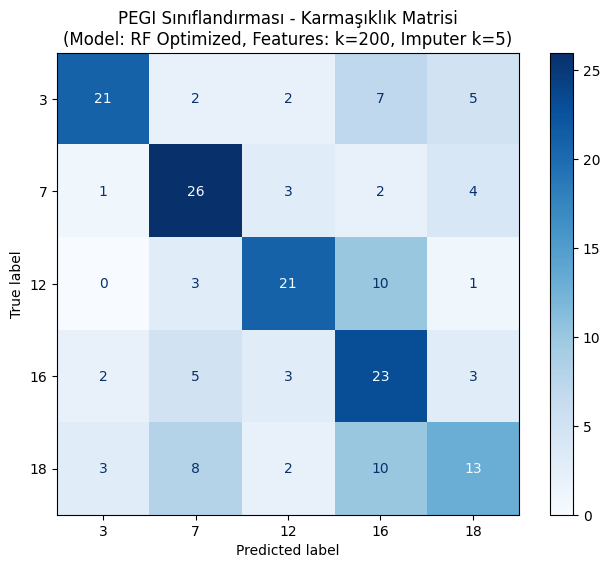

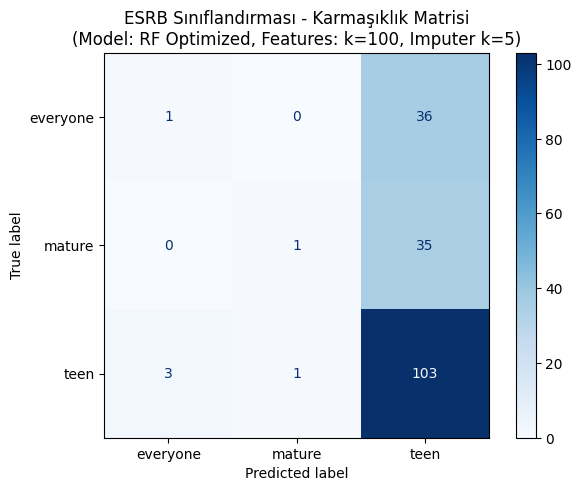

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

try:
    k_imp_final = 5
    best_k_pegi_final = 200 
    best_k_esrb_final = 100 

    print("Nihai tahminler için k_imp=5 süreci kontrol ediliyor/yeniden çalıştırılıyor...")
    target_pegi_orig = df['PEGI']
    target_esrb_orig = df['ESRB']
    features_df_orig = df.drop(columns=['PEGI', 'ESRB'])
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_df_orig)
    imputer = KNNImputer(n_neighbors=k_imp_final)
    features_imputed_scaled = imputer.fit_transform(features_scaled)
    X_processed = pd.DataFrame(features_imputed_scaled, columns=features_df_orig.columns, index=df.index)
    
    X_train, X_test, y_train_pegi, y_test_pegi = train_test_split(
        X_processed, target_pegi_orig, test_size=test_size_ratio, random_state=random_state_value, stratify=target_pegi_orig)
    _, _, y_train_esrb, y_test_esrb = train_test_split(
        X_processed, target_esrb_orig, test_size=test_size_ratio, random_state=random_state_value, stratify=target_esrb_orig)
    le = LabelEncoder()
    y_train_esrb_encoded = le.fit_transform(y_train_esrb)
    y_test_esrb_encoded = le.transform(y_test_esrb)
    esrb_target_names = le.classes_
    pegi_target_names = [str(c) for c in sorted(target_pegi_orig.unique())]

    selector_pegi = SelectKBest(score_func=f_classif, k=best_k_pegi_final)
    X_train_pegi_selected = selector_pegi.fit_transform(X_train, y_train_pegi)
    X_test_pegi_selected = selector_pegi.transform(X_test)
    selector_esrb = SelectKBest(score_func=f_classif, k=best_k_esrb_final)
    X_train_esrb_selected = selector_esrb.fit_transform(X_train, y_train_esrb_encoded)
    X_test_esrb_selected = selector_esrb.transform(X_test)
    
    final_model_pegi = RandomForestClassifier(**best_params_pegi)
    final_model_pegi.fit(X_train_pegi_selected, y_train_pegi)
    y_pred_pegi_final = final_model_pegi.predict(X_test_pegi_selected)

    final_model_esrb = RandomForestClassifier(**best_params_esrb)
    final_model_esrb.fit(X_train_esrb_selected, y_train_esrb_encoded)
    y_pred_esrb_encoded_final = final_model_esrb.predict(X_test_esrb_selected)
    print("Nihai tahminler başarıyla oluşturuldu/kontrol edildi.")

    print("\n1. Nihai Modellerin Karmaşıklık Matrisleri")
    
    cm_pegi = confusion_matrix(y_test_pegi, y_pred_pegi_final)
    disp_pegi = ConfusionMatrixDisplay(confusion_matrix=cm_pegi, display_labels=pegi_target_names)
    fig_pegi, ax_pegi = plt.subplots(figsize=(8, 6))
    disp_pegi.plot(ax=ax_pegi, cmap=plt.cm.Blues)
    ax_pegi.set_title('PEGI Sınıflandırması - Karmaşıklık Matrisi\n(Model: RF Optimized, Features: k=200, Imputer k=5)')
    plt.show()

    cm_esrb = confusion_matrix(y_test_esrb_encoded, y_pred_esrb_encoded_final)
    disp_esrb = ConfusionMatrixDisplay(confusion_matrix=cm_esrb, display_labels=esrb_target_names)
    fig_esrb, ax_esrb = plt.subplots(figsize=(7, 5))
    disp_esrb.plot(ax=ax_esrb, cmap=plt.cm.Blues)
    ax_esrb.set_title('ESRB Sınıflandırması - Karmaşıklık Matrisi\n(Model: RF Optimized, Features: k=100, Imputer k=5)')
    plt.show()

except NameError as e:
    print(f"HATA: Karmaşıklık matrisi çizimi için gerekli değişken bulunamadı ({e}). Lütfen önceki adımları kontrol edin.")
except Exception as e:
    print(f"HATA: Karmaşıklık matrisi çizilirken bir sorun oluştu: {e}")

## 9. Conclusion

### 9.1. Summary of Findings
Briefly summarize the key findings from the EDA, model comparisons, and optimization steps. Mention which imputation k, feature count k, and model hyperparameters worked best for each task.

### 9.2. Final Model Configurations
Explicitly state the final configuration chosen for each task:
- **PEGI:** Imputer, Feature Selector (k), Model (with hyperparameters).
- **ESRB:** Imputer, Feature Selector (k), Model (with hyperparameters).

### 9.3. Final Performance
Report the final test set performance metrics (Accuracy, Weighted F1, Macro F1, and possibly the Classification Report) for the chosen configurations for both PEGI and ESRB.

### 9.4. Limitations and Future Work
Discuss any limitations encountered (e.g., dataset size, feature type, class imbalance challenges, specific model weaknesses). Suggest potential areas for future improvement (e.g., trying different imputation methods, feature selection techniques like RFE or model-based importance, different algorithms like XGBoost, techniques for handling class imbalance like SMOTE).